In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchsummary import summary
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter

import os

In [2]:
from models import ConditionalGenerator, Classificator
from utils import noise

In [3]:
# delete the runs folder
if os.path.exists("runs"):
    os.system("rm -r runs")

In [4]:
# fashion mnist dataset
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

trainset = datasets.FashionMNIST(
    "~/.pytorch/F_MNIST_data/", download=True, train=True, transform=transform
)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST(
    "~/.pytorch/F_MNIST_data/", download=True, train=False, transform=transform
)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

### Parameters 

In [5]:
epochs = 70
n_classes = len(trainset.classes)
latent_dim = 100
embedding_dim = 100
lr = 0.00001
beta1 = 0.5
beta2 = 0.999
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
Loss_D = nn.BCELoss()

G = ConditionalGenerator(
    n_classes=n_classes, embedding_dim=embedding_dim, latent_dim=latent_dim
).to(device)
D = Classificator(1, embedding_dim=embedding_dim, n_classes=n_classes).to(device)
G_optim = optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
D_optim = optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))

G_scheduler = lr_scheduler.StepLR(G_optim, step_size=30, gamma=0.1)
D_scheduler = lr_scheduler.StepLR(D_optim, step_size=30, gamma=0.1)

writer = SummaryWriter()

In [ ]:
fixed_noise = noise(50, latent_dim).to(device)
fixed_labels = torch.tensor([i for i in range(10) for _ in range(5)]).long().to(device)
fixed_outputs = []
all_labels = torch.tensor([i for i in range(10)]).long().to(device)

pbar = tqdm(total=epochs * len(trainloader))
for epoch in range(epochs):
    for i, (images, labels) in enumerate(trainloader):

        batch_size = images.size(0)
        images = images.to(device)
        labels = labels.long().to(device)

        # Train Discriminator
        D_optim.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        real_output = D(images, labels)
        real_loss = Loss_D(real_output, real_labels)

        z = noise(batch_size, latent_dim).to(device)
        fake_images = G(z, labels)
        fake_output = D(fake_images.detach(), labels)
        fake_loss = Loss_D(fake_output, fake_labels)

        D_loss = real_loss + fake_loss
        D_loss.backward()
        D_optim.step()

        # Train Generator
        G_optim.zero_grad()
        z = noise(batch_size, latent_dim).to(device)
        fake_images = G(z, labels)
        fake_output = D(fake_images, labels)

        G_loss = Loss_D(fake_output, real_labels)
        G_loss.backward()
        G_optim.step()

        pbar.update()
        if i % 50 == 0:
            pbar.set_description(
                f"Epoch: {epoch}, Iteration: {i}, D_loss: {D_loss.item():.3f}, G_loss: {G_loss.item():.3f}"
            )

            with torch.no_grad():
                G.eval()
                fixed_output = ((G(fixed_noise, fixed_labels) + 1) / 2).clamp(0, 1)
                fixed_outputs.append(fixed_output.detach().cpu())
                writer.add_images(
                    "generated",
                    make_grid(fixed_output, nrow=5).unsqueeze(0),
                    epoch * len(trainloader) + i,
                )
                G.train()

        writer.add_scalar("D_loss", D_loss.item(), epoch * len(trainloader) + i)
        writer.add_scalar("G_loss", G_loss.item(), epoch * len(trainloader) + i)

    G_scheduler.step()
    D_scheduler.step()

  0%|          | 0/65660 [00:00<?, ?it/s]

In [8]:
from matplotlib import animation

MovieWriter ffmpeg unavailable; using Pillow instead.


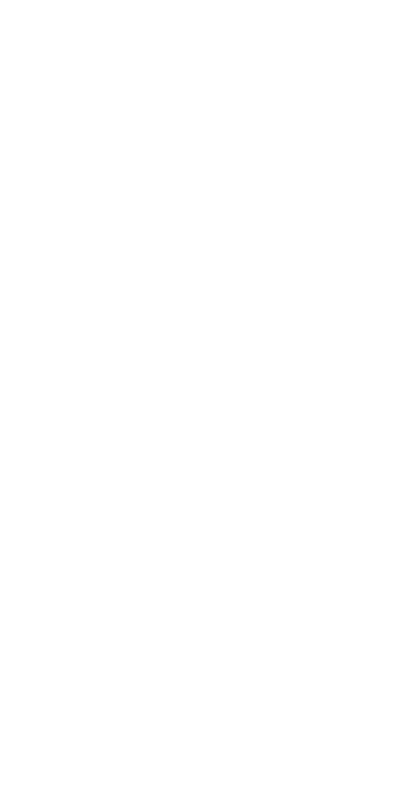

In [ ]:
writer.close()
fig = plt.figure(figsize=(10, 10))
plt.axis("off")

images = [
    [
        plt.imshow(
            make_grid(fixed_output, nrow=5).permute(1, 2, 0).numpy(),
            cmap="gray",
            animated=True,
        )
    ]
    for fixed_output in fixed_outputs
]

ani = animation.ArtistAnimation(fig, images, interval=200, repeat_delay=10000)
ani.save("fashion_mnist.gif")

In [10]:
# Test the discriminator

confusion_matrices = np.zeros((n_classes, 2, 2))

D.eval()
G.eval()

with torch.no_grad():
    for images, labels in testloader:
        batch_size = images.size(0)

        images = images.to(device)
        labels = labels.to(device)
        outputs = D(images, labels)

        predicted = outputs > 0.5

        for label, pred in zip(labels, predicted):
            confusion_matrices[label][pred][1] += 1

        z = noise(batch_size, latent_dim).to(device)
        fake_images = G(z, labels)
        outputs = D(fake_images, labels)

        predicted = outputs > 0.5

        for label, pred in zip(labels, predicted):
            confusion_matrices[label][pred][0] += 1

In [11]:
for i, confusion_matrix in enumerate(confusion_matrices):
    print(f"Confusion matrix for class {i}: \n{confusion_matrix}")

print(f"Overall confusion matrix :  \n{confusion_matrices.sum(axis=0)}")

print(f"Accuracy: {confusion_matrices.sum(axis=0).trace() / confusion_matrices.sum()}")
print(f"Precision: {confusion_matrices[:, 1, 1].sum() / confusion_matrices[:, 1].sum()}")
print(f"Recall: {confusion_matrices[:, 1, 1].sum() / confusion_matrices[:, :, 1].sum()}")
print(
    f"False positive rate: {confusion_matrices[:, 1, 0].sum() / confusion_matrices[:, :, 0].sum()}"
)

Confusion matrix for class 0: 
[[1000.  231.]
 [   0.  769.]]
Confusion matrix for class 1: 
[[1000.  396.]
 [   0.  604.]]
Confusion matrix for class 2: 
[[1000.  381.]
 [   0.  619.]]
Confusion matrix for class 3: 
[[1000.  445.]
 [   0.  555.]]
Confusion matrix for class 4: 
[[1000.  320.]
 [   0.  680.]]
Confusion matrix for class 5: 
[[1000.  347.]
 [   0.  653.]]
Confusion matrix for class 6: 
[[1000.  353.]
 [   0.  647.]]
Confusion matrix for class 7: 
[[1000.  566.]
 [   0.  434.]]
Confusion matrix for class 8: 
[[1000.  527.]
 [   0.  473.]]
Confusion matrix for class 9: 
[[1000.  400.]
 [   0.  600.]]
Overall confusion matrix :  
[[10000.  3966.]
 [    0.  6034.]]
Accuracy: 0.8017
Precision: 1.0
Recall: 0.6034
False positive rate: 0.0


As we can see the Discriminator has the edge on the Generator, making near perfect classification of generated samples (only misclassifying them 0.1% of the time), at the cost of quite a few misclassifications on the original dataset, maintaining however a 81% recall.